# Imports Iniciais

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
!python -m spacy download pt_core_news_sm
!pip install googletrans==4.0.0-rc1
!pip install enelvo

  Using cached https://github.com/explosion/spacy-models/releases/download/pt_core_news_sm-3.7.0/pt_core_news_sm-3.7.0-py3-none-any.whl (13.0 MB)
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [31]:
from google.colab import drive
from googletrans import Translator
from enelvo.normaliser import Normaliser
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Dense, Concatenate, Input, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from unittest.mock import patch, MagicMock
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import unittest
import numpy as np
import pandas as pd
import spacy
import nltk
import time

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Pré-processamento

## 0) Base de Dados

In [32]:
norm = Normaliser(tokenizer='readable')
chats_clients = pd.read_csv('/content/drive/Shareddrives/grupo3moshi/augmented_data.csv')
chats_clients.head()

,No,Intencao,Pergunta,Resposta
0,1,Como depositar,Boa dia.tudo bem?eu gostaria de saber sobre aq...,"Bom dia! Sim, o sr pode utilizar o cartão de d..."
1,2,Como fazer remessa,Como enviar dinheiro do Japão?,"Para se inscrever no serviço de remessa, por f..."
2,3,Tempo de remessa,Quanto tempo levará para o beneficiário recebe...,"Via de regra, as remessas serão pagas via PIX ..."
3,4,"Pedido de envio via metodo ""ByPhone""",Boa tarde Acabei de fazer a transferência de 2...,iremos processar a sua solicitacao. Muito obri...
4,5,"Pedido de envio via metodo ""ByPhone""",Poderia fazer a remessa de 22yenes para o BBB ...,iremos processar a sua solicitacao. Muito obri...


In [33]:
chats_clients.fillna('erro ao processar a pergunta', inplace=True)

In [34]:
nlp_pt = spacy.load("pt_core_news_sm")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [35]:
def correct_grammar(text):
  return norm.normalise(text)

## 1) Word2Vec

O processo de Word2Vec é uma técnica de aprendizado de máquina com o objetivo de vetorizar palavras almejando preservar o contexto, convertendo o resultado para a forma numérica, para que os dados possam ser utilizados em modelos de aprendizado de máquina.

O Word2Vec pode possuir 2 arquiteturas, sendo elas:

- Skip-Gram: rede tenta prever as palavras de contexto ao redor de uma palavra central
- CBOW: rede tenta prever a palavra central com base no contexto ao redor da palavra central.

Para fins de comparação, ambas as técnicas serão abordadas no código a seguir:

### 1.1) Skip-Gram

In [36]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Tokenizando as colunas
chats_clients['Pergunta_tokens'] = chats_clients['Pergunta'].apply(lambda x: word_tokenize(x.lower()))
chats_clients['Resposta_tokens'] = chats_clients['Resposta'].apply(lambda x: word_tokenize(x.lower()))

# Unindo as listas de tokens de Pergunta e Resposta para o modelo processar a lista
sentences_skip = chats_clients['Pergunta_tokens'].tolist() + chats_clients['Resposta_tokens'].tolist()

# Utilizando o modelo Word2Vec
model = Word2Vec(sentences_skip, vector_size=100, window=5, min_count=1, sg=1)  #sg=1 para Skip-Gram

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 1.2) Resultados Obtidos

In [37]:
# Acessando o vetor de uma palavra
vector_dia_skip = model.wv['dia']
print(vector_dia_skip)

[-4.74698782e-01  4.77278620e-01  5.37274331e-02  1.25162154e-01
 -2.47629806e-01 -4.60959554e-01  2.47102812e-01  2.88301140e-01
 -3.62030596e-01  1.03786148e-01 -8.25722795e-03 -1.23395331e-01
  5.87834179e-01  2.77264148e-01 -2.87597984e-01 -6.34016454e-01
  4.56600845e-01  4.03200239e-02 -6.90548122e-02  1.09462254e-01
 -3.93851399e-02  3.74751180e-01 -4.75391820e-02 -1.70882225e-01
 -1.70072928e-01  6.11700833e-01 -3.32096517e-01  1.48917437e-01
 -3.48510832e-01 -1.85095489e-01  2.77119607e-01  9.99107659e-02
  6.16026460e-04  4.44677085e-01 -2.80778944e-01  4.53480810e-01
  3.65515463e-02 -6.18017554e-01 -7.86318257e-02  4.61618379e-02
 -5.22372313e-02  1.09487839e-01  2.85190195e-01 -1.78177088e-01
  1.44682363e-01  1.76519111e-01 -4.86327350e-01 -2.36685842e-01
 -2.66419232e-01 -5.66667557e-01 -5.38444102e-01 -2.74832368e-01
 -1.91303819e-01  6.96379125e-01 -4.68848974e-01  2.83572376e-01
 -2.57692114e-02 -3.42592359e-01 -1.31994069e-01  2.54294813e-01
  2.66978055e-01 -2.12994

In [38]:
# Encontrando palavras similares
similar_words_dia_skip = model.wv.most_similar('dia')
print(similar_words_dia_skip)

[('bom', 0.6694803833961487), ('plantão', 0.6069967150688171), ('especial', 0.5934783220291138), ('jornada', 0.5911963582038879), ('#', 0.5724014043807983), ('thiago', 0.5534824728965759), ('3200326', 0.5516548156738281), ('5638010', 0.548510730266571), ('período', 0.544021725654602), ('cabelo', 0.5417757034301758)]


In [39]:
# Encontrando palavras similares
similar_words_bom_skip = model.wv.most_similar('bom')
print(similar_words_bom_skip)

[('dia', 0.6694804430007935), ('vantajoso', 0.6340170502662659), ('benéfico', 0.6286606192588806), ('3200326', 0.5574079751968384), ('concorde', 0.5541884303092957), ('especial', 0.5471044182777405), ('thiago', 0.5458383560180664), ('processaremos', 0.5375887751579285), ('flavia', 0.5367264747619629), ('895', 0.5355356335639954)]


In [40]:
# Encontrando palavras similares
similar_words_dinheiro_skip = model.wv.most_similar('dinheiro')
print(similar_words_dinheiro_skip)

[('numerário', 0.6282315254211426), ('sul', 0.6230457425117493), ('moeda', 0.6178629398345947), ('cache', 0.6108894944190979), ('espécie', 0.6081855893135071), ('coreia', 0.6077291369438171), ('cobre', 0.5925191044807434), ('arrumar', 0.5881178379058838), ('massa', 0.5817692875862122), ('cunhada', 0.5722939372062683)]


In [41]:
# Encontrando palavras similares
similar_words_pix_skip = model.wv.most_similar('pix')
print(similar_words_pix_skip)

[('feitos', 0.837505042552948), ('realizadas', 0.8220529556274414), ('autoestradas', 0.7990132570266724), ('via', 0.7930697798728943), ('pagos', 0.7925318479537964), ('estrada', 0.7862152457237244), ('chegam', 0.7835984230041504), ('pix.os', 0.7786077260971069), ('sadio', 0.7766505479812622), ('estradas', 0.7700449824333191)]


### 2.1) CBOW

In [42]:
# Unindo as listas de tokens de Pergunta e Resposta para o modelo processar a lista
sentences_CBOW = chats_clients['Pergunta_tokens'].tolist() + chats_clients['Resposta_tokens'].tolist()

# Utilizando o modelo Word2Vec
model_cbow = Word2Vec(sentences_CBOW, vector_size=100, window=5, min_count=1, sg=0)  #sg=0 para CBOW

### 2.2) Resultados Obtidos

In [43]:
# Acessando o vetor de uma palavra
vector_dia_cbow = model_cbow.wv['dia']
print(vector_dia_cbow)

[-1.4603885  -0.02977032 -0.0449644   1.1239034  -0.50897795 -0.39553514
 -0.6421216   1.1947569  -1.7811872   0.4181157  -0.35767058 -0.42591646
  0.4912894   0.2140074  -1.0771801  -1.1572016  -0.82137376 -0.43916684
 -0.2271982   1.0143199  -0.45442942  0.2943575   0.3197069  -0.10367458
 -0.50919855  0.13475804 -0.8648447   0.8165426  -0.10425369 -0.9475033
 -0.27811348 -0.2703944   0.05985063  0.1537483   0.60512424  1.6466128
  0.6161544  -1.0879501  -1.2985092   0.60228187 -0.10077604 -0.01860563
 -0.7672489  -0.01518378  0.7285217  -0.23824042 -0.26121294 -1.4210458
  0.202157   -1.2893903  -0.00327107 -0.31375575  0.06586687  1.6471158
 -0.68995064 -0.03176086  0.17645368 -0.94690615  0.08405814  0.8445196
  0.11752795 -0.27725804  0.35023606 -0.06005535  0.3449122  -0.16484179
 -0.3959492   0.7608883  -0.30395153  0.8989431  -0.73517114  0.9719954
 -0.05213404 -0.05969968  0.28799605  0.19460464 -0.31199273  0.5424248
  0.58754784 -0.41575018 -0.16860919 -0.5380217  -0.058919

In [44]:
# Encontrando palavras similares
similar_words_dia_cbow = model_cbow.wv.most_similar('dia')
print(similar_words_dia_cbow)

[('flavia', 0.6395354270935059), ('terezinha', 0.6171176433563232), ('ajuda', 0.5744609832763672), ('thiago', 0.5679051280021667), ('chamo', 0.566500186920166), ('450.000', 0.5651554465293884), ('jornada', 0.5601615905761719), ('plantão', 0.5564466714859009), ('solicitaremos', 0.5524442791938782), ('onten', 0.549135148525238)]


In [45]:
# Encontrando palavras similares
similar_words_bom_cbow = model_cbow.wv.most_similar('bom')
print(similar_words_bom_cbow)

[('vantajoso', 0.6494183540344238), ('benéfico', 0.6125480532646179), ('especial', 0.6117791533470154), ('plantão', 0.6030769944190979), ('flavia', 0.572119951248169), ('450.000', 0.5653576254844666), ('ajuda', 0.5518401861190796), ('manutenção', 0.5492056012153625), ('saindo', 0.53752601146698), ('25', 0.5300670862197876)]


In [46]:
# Encontrando palavras similares
similar_words_dinheiro_cbow = model_cbow.wv.most_similar('dinheiro')
print(similar_words_dinheiro_cbow)

[('remessar', 0.6896278858184814), ('numerário', 0.6868902444839478), ('poder', 0.6828094720840454), ('japão', 0.6758972406387329), ('enviam', 0.6726282835006714), ('envia', 0.671607494354248), ('urgente', 0.6625063419342041), ('moeda', 0.66004478931427), ('volta', 0.6578474044799805), ('moedas', 0.6549120545387268)]


In [47]:
# Encontrando palavras similares
similar_words_pix_cbow = model_cbow.wv.most_similar('pix')
print(similar_words_pix_cbow)

[('sendo', 0.9282107949256897), ('feitos', 0.8999865055084229), ('via', 0.8960664868354797), ('pagamentos', 0.8783480525016785), ('realizadas', 0.8549642562866211), ('pix.os', 0.8471940159797668), ('autoestradas', 0.8309575319290161), ('ted', 0.8111361265182495), ('pagas', 0.8089029788970947), ('estão', 0.8062918782234192)]


### 3.1) Word Embedding


Dessa forma, é fundamental gerar os embedding das colunas para que futuros modelos de aprendizado de máquina possam compreender e utilizar os dados de cada frase. Para tal, será utilizado uma média dos vetores de cada frase, desenvolvido a seguir, utilizando a abordagem CBOW (padrão):


In [48]:
import numpy as np

# Função para gerar o embedding médio de uma frase
def get_sentence_embedding(tokens, model):
    word_vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

### 3.2) Resultados Obtidos

In [49]:
# Aplicando a função para gerar os embeddings e salvando nas novas colunas
chats_clients['Pergunta_embedding'] = chats_clients['Pergunta_tokens'].apply(lambda tokens: get_sentence_embedding(tokens, model_cbow))
chats_clients['Resposta_embedding'] = chats_clients['Resposta_tokens'].apply(lambda tokens: get_sentence_embedding(tokens, model_cbow))

In [50]:
chats_clients['Pergunta_embedding'].head()

,Pergunta_embedding
0,"[-0.535882, 0.027550427, -0.029907012, -0.3127..."
1,"[-0.90503454, -0.61296564, -0.18629377, -1.028..."
2,"[-0.6930833, -0.21701029, -0.4007078, -0.88623..."
3,"[-0.6189343, 0.68792194, -0.24192277, -0.38637..."
4,"[-0.5062939, 0.43368223, 0.08921132, -0.144527..."


In [51]:
chats_clients['Resposta_embedding'].head()

,Resposta_embedding
0,"[-0.2864641, -0.06725503, -0.17957851, -0.2332..."
1,"[-0.83850735, -0.015436354, -0.12764171, -0.60..."
2,"[0.028646778, -0.52710533, 0.30376318, -0.2769..."
3,"[0.036766224, 0.41849542, 0.08030974, 0.649186..."
4,"[0.036766224, 0.41849542, 0.08030974, 0.649186..."


## 2) Base de Dados Final

In [52]:
chats_clients

,No,Intencao,Pergunta,Resposta,Pergunta_tokens,Resposta_tokens,Pergunta_embedding,Resposta_embedding
0,1,Como depositar,Boa dia.tudo bem?eu gostaria de saber sobre aq...,"Bom dia! Sim, o sr pode utilizar o cartão de d...","[boa, dia.tudo, bem, ?, eu, gostaria, de, sabe...","[bom, dia, !, sim, ,, o, sr, pode, utilizar, o...","[-0.535882, 0.027550427, -0.029907012, -0.3127...","[-0.2864641, -0.06725503, -0.17957851, -0.2332..."
1,2,Como fazer remessa,Como enviar dinheiro do Japão?,"Para se inscrever no serviço de remessa, por f...","[como, enviar, dinheiro, do, japão, ?]","[para, se, inscrever, no, serviço, de, remessa...","[-0.90503454, -0.61296564, -0.18629377, -1.028...","[-0.83850735, -0.015436354, -0.12764171, -0.60..."
2,3,Tempo de remessa,Quanto tempo levará para o beneficiário recebe...,"Via de regra, as remessas serão pagas via PIX ...","[quanto, tempo, levará, para, o, beneficiário,...","[via, de, regra, ,, as, remessas, serão, pagas...","[-0.6930833, -0.21701029, -0.4007078, -0.88623...","[0.028646778, -0.52710533, 0.30376318, -0.2769..."
3,4,"Pedido de envio via metodo ""ByPhone""",Boa tarde Acabei de fazer a transferência de 2...,iremos processar a sua solicitacao. Muito obri...,"[boa, tarde, acabei, de, fazer, a, transferênc...","[iremos, processar, a, sua, solicitacao, ., mu...","[-0.6189343, 0.68792194, -0.24192277, -0.38637...","[0.036766224, 0.41849542, 0.08030974, 0.649186..."
4,5,"Pedido de envio via metodo ""ByPhone""",Poderia fazer a remessa de 22yenes para o BBB ...,iremos processar a sua solicitacao. Muito obri...,"[poderia, fazer, a, remessa, de, 22yenes, para...","[iremos, processar, a, sua, solicitacao, ., mu...","[-0.5062939, 0.43368223, 0.08921132, -0.144527...","[0.036766224, 0.41849542, 0.08030974, 0.649186..."
...,...,...,...,...,...,...,...,...
5631,1327,Como depositar,"ola Olá, posso ajudar? Aguardando o no meu app...",O código de depósito vai estar no seu aplicati...,"[ola, olá, ,, posso, ajudar, ?, aguardando, o,...","[o, código, de, depósito, vai, estar, no, seu,...","[-0.44714928, 0.18715721, 0.056103088, -0.3996...","[-0.41224903, 0.3192163, 0.063063234, -0.40836..."
5632,1327,Como depositar,"ola Olá, como posso ajudar? o depósito no meu ...",O valor já consta no seu saldo,"[ola, olá, ,, como, posso, ajudar, ?, o, depós...","[o, valor, já, consta, no, seu, saldo]","[-0.46795827, 0.19233854, 0.02176102, -0.37907...","[-1.0452499, -0.35943624, -0.12605108, -0.1383..."
5633,1327,Como depositar,"ola Olá, como posso ajudar? Aguardando o depós...",Igualmente,"[ola, olá, ,, como, posso, ajudar, ?, aguardan...",[igualmente],"[-0.462852, 0.17762174, 0.024709387, -0.376368...","[-0.054407578, 0.06989633, -0.047331356, 0.026..."
5634,1328,Cadastro de beneficiario,Boa Vc pode me enviar prwcisa pra registra pes...,"Bom dia, DADOS DO BENEFICIÁRIO NOME COMPLETO...","[boa, vc, pode, me, enviar, prwcisa, pra, regi...","[bom, dia, ,, dados, do, beneficiário, nome, c...","[-0.39906645, -0.038844313, -0.16953902, -0.42...","[-0.7520356, 0.43312365, 0.6335631, -0.2162484..."


### Classificador de intenção

O classificador de intenção é um sistema que identifica a intenção por trás de uma mensagem de texto, neste caso, seria as mensagens (entradas do chatbot) enviadas pelos clientes. A intenção refere-se ao que o usuário deseja realizar, como transferir dinheiro, taxa de câmbio, etc.
Nesta seção é abordado o treinamento do modelo com suas respectivas métricas (Acurácia, Recall, F1-Score).

Abaixo há uma classe de callback que guarda as métricas de F1-Score e recall. A F1-score é uma métrica que leva em consideração a precisão e o recall, sendo definida pela seguinte fórmula:
$$ F1-Score = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

F1 é conhecido como a média harmônica da precisão e do recall. A pontuação F1 se torna 1 apenas se a precisão e recall são 1. Se a precisão e o recall são altos, logo o valor de F1 também é alta.

a métrica Recall (sensibilidade) ajuda a avaliar a capacidade do modelo de identificar corretamente todos os exemplos positivos de uma classe. Por exemplo, se temos um problema onde devemos classificar com uma classificação "sim" ou "não" referente a spam de e-mails, o recall nesse caso nos dirá quantos e-mails de spam o modelo conseguiu identificar corretamente, dentre todos os e-mails que realmente eram spam.

A fórmula do recall é a seguinte:

$$ Recall = \frac{TP}{TP + FN}$$

Já a acurácia é a proporção total de exemplos que o modelo classificou corretamente, ou seja, o quanto o modelo conseguiu acertar. Fórmula:


$$ Recall = \frac{Previsões corretas}{Previsões incorretas}$$

In [53]:
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = self.validation_data
        val_pred = np.argmax(self.model.predict(val_data), axis=1)
        val_f1 = f1_score(val_labels, val_pred, average='macro')
        recall = recall_score(val_labels, val_pred, average='macro', zero_division=1)
        print(f'Epoch {epoch + 1}: f1-score: {val_f1:.4f} - recall: {recall:.4f}')
        logs['f1_score'] = val_f1
        logs['recall'] = recall

#### Modelo Final

In [54]:
class IntentClassifier:
    def __init__(self, epochs=300, batch_size=16, test_size=0.3, validation_split=0.3, learning_rate=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.test_size = test_size
        self.validation_split = validation_split
        self.learning_rate = learning_rate
        self.model = None
        self.label_encoder = None

    def prepare_data(self, chats_clients):
        answer_embeddings = np.array(chats_clients['Pergunta_embedding'].tolist())

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(chats_clients['Intencao'])

        # Ajuste para garantir que a entrada seja 3D
        answer_embeddings = answer_embeddings.reshape((answer_embeddings.shape[0], 1, answer_embeddings.shape[1]))

        X_train, X_test, y_train, y_test = train_test_split(answer_embeddings, self.labels, test_size=self.test_size, random_state=42)

        return X_train, X_test, y_train, y_test

    def build_model(self, input_shape):
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
        self.model.add(Dropout(0.4))
        self.model.add(LSTM(64))
        self.model.add(Dropout(0.4))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(len(np.unique(self.labels)), activation='softmax'))
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def train(self, X_train, X_test, y_train, y_test):
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

        # Callback do F1-Score e recall
        metrics_callback = MetricsCallback(validation_data=(X_test, y_test))

        H = self.model.fit(X_train, y_train, epochs=self.epochs,
                       batch_size=self.batch_size,
                       validation_split=self.validation_split,
                       callbacks=[
                           model_checkpoint,
                           metrics_callback
                           ])

        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

        return H

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        return y_pred_classes

    def generate_report(self, y_test, y_pred_classes):
      print(len(y_test))
      print(classification_report(y_test, y_pred_classes))

    def evaluate_model(self, H):
      # Obter métricas de precisão e perda do treinamento
      acc = H.history['accuracy']
      val_acc = H.history['val_accuracy']
      loss = H.history['loss']
      val_loss = H.history['val_loss']

      epochs = range(1, len(acc) + 1)

      # Plotar precisão do conjunto
      plt.subplot(2, 2, 3)
      plt.plot(epochs, acc, 'r', label='Precisão do Conjunto de Treino')
      plt.plot(epochs, val_acc, 'b', label='Precisão do Conjunto de Validação')
      plt.title('Precisão do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Precisão')
      plt.legend()

      # Plotar perda do conjunto
      plt.subplot(2, 2, 4)
      plt.plot(epochs, loss, 'r', label='Perda do Conjunto de Treino')
      plt.plot(epochs, val_loss, 'b', label='Perda do Conjunto de Validação')
      plt.title('Perda do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Perda')
      plt.legend()

      plt.tight_layout()
      plt.show()

#### Treino e Avaliação com CPU

Para rodar o modelo com a CPU basta alocar qualquer máquina do colab, rodar todas as células anteriores e rodar a célula abaixo.



In [55]:
classifier = IntentClassifier()
X_train, X_test, y_train, y_test = classifier.prepare_data(chats_clients)
classifier.build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
with tf.device('/cpu:0'):
  # Calcula o tempo da cpu
  start_time = time.time()
  H = classifier.train(X_train, X_test, y_train, y_test)
  # Para o cronômetro e salva o tempo da cpu
  time_cpu = time.time() - start_time
  H

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Epoch 1: f1-score: 0.1229 - recall: 0.1655
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.2376 - loss: 2.8432 - val_accuracy: 0.4654 - val_loss: 1.9207 - f1_score: 0.1229 - recall: 0.1655
Epoch 2/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 2: f1-score: 0.1658 - recall: 0.2099
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4584 - loss: 1.9181 - val_accuracy: 0.5329 - val_loss: 1.5565 - f1_score: 0.1658 - recall: 0.2099
Epoch 3/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 3: f1-score: 0.2205 - recall: 0.2572
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5224 - loss: 1.6332 - val_accuracy: 0.5650 - val_loss: 1.4325 - f1_score: 0.2205 - recall: 0.2572
Epoch 4/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 4: f1-score: 0.2440 - recall: 0.2692
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5387 - loss: 1.4949 - val_accuracy: 0.5735 - val_loss: 1.3736 - f1_score: 0.2440 - recall: 0.2692
Epoch 5/

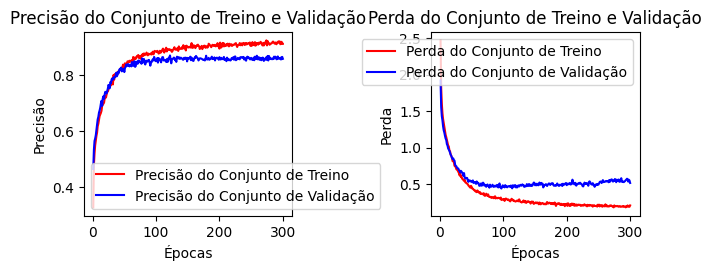

In [56]:
classifier.evaluate_model(H)

In [57]:
y_pred_classes = classifier.predict(X_test)
classifier.generate_report(y_test, y_pred_classes)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1691
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        50
           1       0.56      0.75      0.64        12
           2       0.95      0.95      0.95        78
           3       1.00      1.00      1.00        26
           4       0.32      0.33      0.32        18
           5       0.96      0.93      0.95        29
           6       0.30      0.35      0.32        17
           7       0.90      0.94      0.92       179
           8       0.99      0.96      0.98       331
           9       0.25      1.00      0.40         2
          10       1.00      1.00      1.00         1
          11       1.00      0.67      0.80        21
          12       0.97      0.99      0.98       199
          13       0.68      0.50      0.58        68
          14       0.75      0.73      0.74       103
          15       0.74      0.69      0.71        65
          16       0.59      0.66    

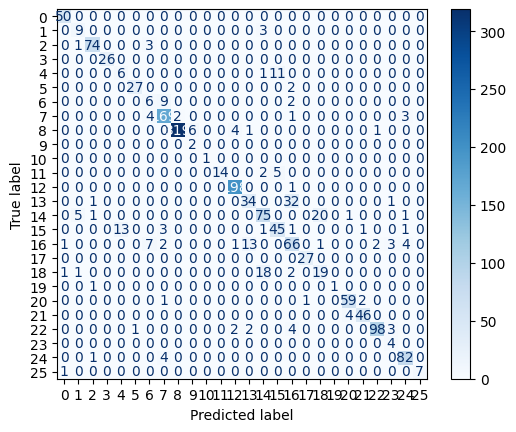

In [58]:
# Calcula a matriz de confusão
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_classes, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### Treino e Avaliação com GPU

Para rodar o modelo com a GPU é necessário alocar uma máquina com GPU, por exemplo a T4 GPU, rodar todas as células anteriores (exceto a de treino com CPU que não é necessária) , e rodar a célula abaixo.

In [59]:
classifier = IntentClassifier()
X_train, X_test, y_train, y_test = classifier.prepare_data(chats_clients)
classifier.build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
with tf.device('/gpu:0'):
  # Calcula o tempo da cpu
  start_time = time.time()
  history = classifier.train(X_train, X_test, y_train, y_test)
  # Para o cronômetro e salva o tempo da cpu
  time_gpu = time.time() - start_time
  history

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 1, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,770 (1.24 MB)

 Trainable params: 323,770 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1: f1-score: 0.1347 - recall: 0.1659
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2340 - loss: 2.8305 - val_accuracy: 0.4738 - val_loss: 1.9077 - f1_score: 0.1347 - recall: 0.1659
Epoch 2/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 2: f1-score: 0.2136 - recall: 0.2477
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4724 - loss: 1.8624 - val_accuracy: 0.5414 - val_loss: 1.5702 - f1_score: 0.2136 - recall: 0.2477
Epoch 3/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 3: f1-score: 0.2271 - recall: 0.2592
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5265 - loss: 1.5997 - val_accuracy: 0.5735 - val_loss: 1.3738 - f1_score: 0.2271 - recall: 0.2592
Epoch 4/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 4: f1-score: 0.2501 - recall: 0.2700
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5565 - loss: 1.4591 - val_accuracy: 0.5870 - val_loss: 1.3284 - f1_score: 0.2501 - recall: 0.2700
Epoch 5/300

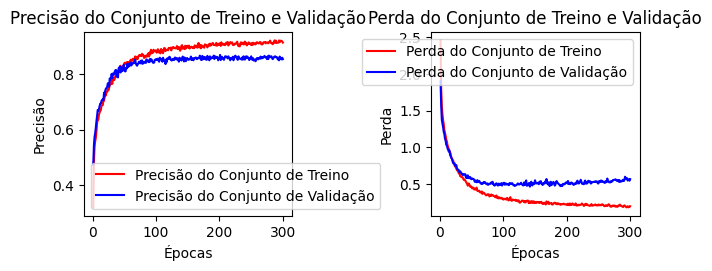

In [65]:
classifier.evaluate_model(history)

In [66]:
y_pred_classes = classifier.predict(X_test)
classifier.generate_report(y_test, y_pred_classes)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1691
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        50
           1       0.60      0.75      0.67        12
           2       0.97      0.96      0.97        78
           3       1.00      0.96      0.98        26
           4       0.26      0.33      0.29        18
           5       0.87      0.93      0.90        29
           6       0.24      0.24      0.24        17
           7       0.89      0.96      0.92       179
           8       0.99      0.97      0.98       331
           9       0.33      1.00      0.50         2
          10       0.50      1.00      0.67         1
          11       1.00      0.76      0.86        21
          12       0.96      1.00      0.98       199
          13       0.65      0.49      0.55        68
          14       0.74      0.68      0.71       103
          15       0.66      0.62      0.63        65
          16       0.59      0.65    

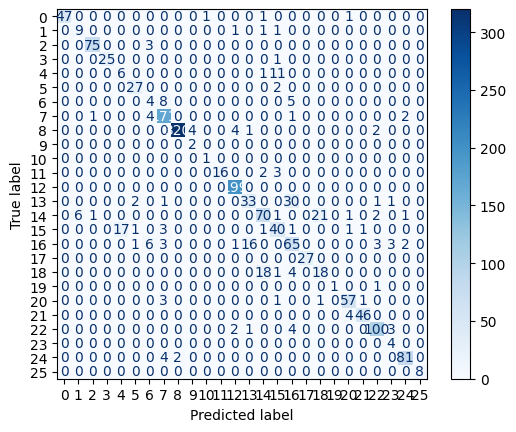

In [67]:
# Calcula a matriz de confusão
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_classes, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

#### Análise entre CPU e GPU


Para rodar esta análise é preciso rodar o modelo com a CPU e a GPU.

Podemos ver que a GPU foi ligeiramente mais rápida, aproximadamente 421 segundos, ou aproximadamente 11%.

In [68]:
print(f'Tempo de treinamento com CPU: {time_cpu}')
print(f'Tempo de treinamento com GPU: {time_gpu}')

Tempo de treinamento com CPU: 478.7049357891083
Tempo de treinamento com GPU: 421.6977219581604


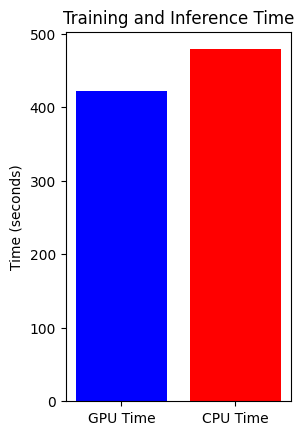

In [69]:
# Plotando o tempo de treinamento e inferência da CPU e GPU
plt.subplot(1, 2, 2)
plt.bar(['GPU Time'], [time_gpu], color=['blue'])
plt.bar(['CPU Time'], [time_cpu], color=['red'])
plt.ylabel('Time (seconds)')
plt.title('Training and Inference Time')

plt.show()